# Bayesian Model Variants

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az
import pymc as pm
import pytensor
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
mlb_injuries = pd.read_csv('mlb_injuries.csv').iloc[:, 1:].copy()
mlb_injuries['age_sq'] = mlb_injuries['age'] ** 2 ## the quadratic component of age
mlb_injuries
pitchers_2025 = mlb_injuries.loc[mlb_injuries['game_year'] == 2025].copy()
## advances time
pitchers_2026 = pitchers_2025.copy()
pitchers_2026['game_year'] = 2026
pitchers_2026['age'] = pitchers_2026['age'] + 1
pitchers_2026['age_sq'] = pitchers_2026['age']**2
pitchers_2026['prev_arm_inj_history'] = (pitchers_2026['prev_arm_inj_history'] + pitchers_2026['had_arm_injury_this_year'].astype(int))
pitchers_2026['had_arm_injury_this_year'] = np.nan

static_cols = ['player_name', 'pitcher', 'birth_country', 'height', 'weight', 'bmi', 'previous_arm_injury_history']
modifiable_cols = [
    'num_pitches_thrown', 'num_games', 'num_bf',
    'bf_per_game', 'pitches_per_game',
    'BB%', 'FB%', 'OS%',
    'BB_avg_velo', 'FB_avg_velo', 'OS_avg_velo',
    'BB_max_velo', 'FB_max_velo', 'OS_max_velo',
    'hrel_sd', 'vrel_sd',
    'BB_avg_spin','BB_avg_ext','BB_avg_ivb','BB_avg_hb','BB_avg_spin_axis',
    'FB_avg_spin','FB_avg_ext','FB_avg_ivb','FB_avg_hb','FB_avg_spin_axis',
    'OS_avg_spin','OS_avg_ext','OS_avg_ivb','OS_avg_hb','OS_avg_spin_axis',
    'BB_max_spin','BB_max_ext','BB_max_ivb','BB_max_hb','BB_max_spin_axis',
    'FB_max_spin','FB_max_ext','FB_max_ivb','FB_max_hb','FB_max_spin_axis',
    'OS_max_spin','OS_max_ext','OS_max_ivb','OS_max_hb','OS_max_spin_axis'
]
pitchers_2026[modifiable_cols] = np.nan

## adds the 2026 data to the df
mlb_extended = pd.concat([mlb_injuries, pitchers_2026], axis=0, ignore_index=True)
mlb_extended

,player_name,pitcher,game_year,num_pitches_thrown,num_games,num_bf,bf_per_game,pitches_per_game,pitcher_role,hrel_sd,vrel_sd,BB%,FB%,OS%,BB_avg_velo,FB_avg_velo,OS_avg_velo,BB_avg_hb,FB_avg_hb,OS_avg_hb,BB_avg_ivb,FB_avg_ivb,OS_avg_ivb,BB_avg_spin,FB_avg_spin,OS_avg_spin,BB_avg_ext,FB_avg_ext,OS_avg_ext,BB_avg_spin_axis,FB_avg_spin_axis,OS_avg_spin_axis,BB_max_velo,FB_max_velo,OS_max_velo,BB_max_hb,FB_max_hb,OS_max_hb,BB_max_ivb,FB_max_ivb,OS_max_ivb,BB_max_spin,FB_max_spin,OS_max_spin,BB_max_ext,FB_max_ext,OS_max_ext,BB_max_spin_axis,FB_max_spin_axis,OS_max_spin_axis,id,birth_year,birth_country,height,weight,age,bmi,had_arm_injury_this_year,prev_arm_inj_history,age_sq
0,jason adam,592094,2018,571.0,31.0,142.0,4.580645,18.419355,RP,0.170480,0.266944,0.309982,0.611208,0.078809,77.410734,94.093123,89.073333,14.580339,-7.237479,-14.816000,-8.945763,15.531576,4.024000,2516.039548,2579.658046,1871.590909,5.863842,6.486819,6.433333,58.474576,204.836676,254.577778,79.7,96.6,91.4,19.44,-1.08,-9.12,0.36,20.52,9.00,2765.0,2902.0,2133.0,6.6,7.0,6.9,91.0,219.0,280.0,592094,1991,USA,1.905004,103.854875,27,28.617731,0.0,0.0,729
1,austin adams,613534,2018,24.0,2.0,7.0,3.500000,12.000000,RP,0.113520,0.133752,0.416667,0.583333,0.000000,88.620000,94.785714,0.000000,6.396000,-3.737143,0.000000,-2.964000,11.640000,0.000000,2716.375000,2496.214286,0.000000,5.280000,5.714286,0.000000,63.200000,197.571429,0.000000,90.5,96.1,0.0,9.36,-0.84,0.00,0.24,16.68,0.00,2928.0,2613.0,0.0,5.5,6.0,0.0,92.0,225.0,0.0,613534,1991,USA,1.905004,99.773243,27,27.493016,0.0,0.0,729
2,chance adams,664856,2018,153.0,3.0,34.0,11.333333,51.000000,RP,0.151870,0.118730,0.326797,0.666667,0.006536,81.434000,92.885294,84.900000,13.166400,-3.587059,-13.800000,-1.984800,14.676471,12.960000,2737.291667,2325.549020,1814.000000,5.852000,6.242157,6.100000,84.800000,193.647059,227.000000,86.7,94.9,84.9,21.00,1.80,-13.80,6.48,18.60,12.96,2979.0,2518.0,1814.0,6.2,6.8,6.1,125.0,213.0,227.0,664856,1994,USA,1.854204,104.308390,24,30.339216,0.0,0.0,576
3,matt albers,458006,2018,672.0,34.0,158.0,4.647059,19.764706,RP,0.163354,0.122160,0.238095,0.648810,0.113095,85.108750,91.657110,83.102632,3.638250,-16.092110,-14.355789,4.254750,8.069450,2.684211,2334.839744,2045.396789,1430.434211,6.082500,6.425000,6.221053,135.868750,243.094037,259.684211,89.1,95.0,86.4,8.88,-7.08,-8.40,13.32,17.64,7.80,2594.0,2398.0,1838.0,6.5,7.6,6.9,212.0,275.0,285.0,458006,1983,USA,1.854204,102.040816,35,29.679668,1.0,0.0,1225
4,sandy alcantara,645261,2018,567.0,6.0,148.0,24.666667,94.500000,SP,0.218418,0.142902,0.268078,0.604938,0.126984,84.908553,95.412828,89.011111,4.432105,-11.618659,-14.683333,0.907895,11.302391,4.380000,2359.910345,2270.113703,1782.549296,5.527632,6.007580,6.104167,102.407895,225.198251,253.305556,89.8,98.8,91.4,11.64,-2.40,-11.40,10.92,19.80,11.28,2624.0,2541.0,2056.0,6.1,6.7,6.7,201.0,269.0,268.0,645261,1995,Dominican Republic,1.955804,90.702948,23,23.712142,1.0,0.0,529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7098,bruce zimmermann,669145,2026,NaN,NaN,NaN,NaN,NaN,SP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,669145,1995,USA,1.905004,107.029478,31,29.492508,NaN,0.0,961
7099,tyler zuber,676604,2026,NaN,NaN,NaN,NaN,NaN,RP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,676604,1995,USA,1.803404,88.435374,31,27.191937,NaN,1.0,961
7100,yosver zulueta,691172,2026,NaN,NaN,NaN,NaN,NaN,RP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,691172,1998,Cuba,1.854

In [3]:
df = mlb_extended.copy()
train_mask = df['had_arm_injury_this_year'].notna()
pred_mask  = df['game_year'] == 2026

## centers age + year
age_mean = df.loc[train_mask, 'age'].mean()
df['age_c'] = df['age'] - age_mean
df['age_c_sq'] = df['age_c'] ** 2
df['year_c'] = df['game_year'] - df.loc[train_mask, 'game_year'].mean()

y = df.loc[train_mask, 'had_arm_injury_this_year'].astype(int).values
X_base = df.loc[:, ['age_c', 'age_c_sq', 'height', 'weight', 'bmi', 'prev_arm_inj_history', 'year_c']]
country_dummies = pd.get_dummies(df['birth_country'], prefix='country', drop_first=True)
role_dummies = pd.get_dummies(df['pitcher_role'], prefix='role', drop_first=True)

workload_features = ['num_pitches_thrown', 'pitches_per_game', 'bf_per_game', 'num_games', 'num_bf']
pitch_mix_features = ['BB%', 'FB%', 'OS%']
velocity_features = ['BB_avg_velo', 'BB_max_velo', 'FB_avg_velo', 'FB_max_velo', 'OS_avg_velo', 'OS_max_velo']
mechanics_features = ['hrel_sd', 'vrel_sd']
biomechanics_features = [
    'BB_avg_spin', 'BB_avg_ext', 'BB_avg_ivb', 'BB_avg_hb', 'BB_avg_spin_axis',
    'BB_max_spin', 'BB_max_ext', 'BB_max_ivb', 'BB_max_hb', 'BB_max_spin_axis',
    'FB_avg_spin', 'FB_avg_ext', 'FB_avg_ivb', 'FB_avg_hb', 'FB_avg_spin_axis',
    'FB_max_spin', 'FB_max_ext', 'FB_max_ivb', 'FB_max_hb', 'FB_max_spin_axis',
    'OS_avg_spin', 'OS_avg_ext', 'OS_avg_ivb', 'OS_avg_hb', 'OS_avg_spin_axis',
    'OS_max_spin', 'OS_max_ext', 'OS_max_ivb', 'OS_max_hb', 'OS_max_spin_axis'
]
role_features = ['pitcher_role']
model2_features = (workload_features + pitch_mix_features + velocity_features + mechanics_features + biomechanics_features + role_features)

X_mod = df[[c for c in model2_features if c != 'pitcher_role']]

X = pd.concat([X_base, country_dummies, X_mod, role_dummies], axis=1).astype(float)
feature_names = X.columns.tolist()

X_train = X.loc[train_mask].copy()
X_2026  = X.loc[pred_mask].copy()

## standardizing the columns
dont_scale = country_dummies.columns.tolist() + role_dummies.columns.tolist()
scale_cols = [c for c in X_train.columns if c not in dont_scale]
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_2026_scaled = X_2026.copy()
X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_2026_scaled[scale_cols]  = scaler.transform(X_2026[scale_cols])

## for the 2026 baseline forecast, we'll replace the NaNs in scaled space with 0 (means of training)
X_2026_scaled_filled = X_2026_scaled.fillna(0.0).copy()
## convers to numpy arrays for PyMC
X_train_mat = X_train_scaled.values
X_2026_mat  = X_2026_scaled_filled.values

In [20]:
coords = {
    "obs": np.arange(X_train_mat.shape[0]),
    "pred": np.arange(X_2026_mat.shape[0]),
    "features": feature_names,
}

with pm.Model(coords=coords) as logit_model_var1:
    # TRAINING DATA
    X_train_data = pm.Data("X_train", X_train_mat, dims=("obs", "features"))
    y_data = pm.Data("y", y, dims=("obs",))

    # PREDICTION DATA
    X_pred_data = pm.Data("X_pred", X_2026_mat, dims=("pred", "features"))

    # PRIORS
    beta_0 = pm.Normal("beta_0", mu=0.0, sigma=2.0)
    beta = pm.Normal("beta", mu=0.0, sigma=0.5, dims="features")

    # TRAINING LINEAR MODEL
    logits_train = beta_0 + pm.math.dot(X_train_data, beta)
    p_train = pm.Deterministic("p_train", pm.math.sigmoid(logits_train), dims=("obs",))

    # PREDICTION LINEAR MODEL
    logits_pred = beta_0 + pm.math.dot(X_pred_data, beta)
    p_pred = pm.Deterministic("p_pred", pm.math.sigmoid(logits_pred), dims=("pred",))

    # LIKELIHOOD
    y_obs = pm.Bernoulli("y_obs", p=p_train, observed=y_data, dims="obs")

In [21]:
with logit_model_var1:
    var1_trace = pm.sample(draws=1000, tune=1000, target_accept=0.97, max_treedepth=20, return_inferencedata=True, sample_kwargs=dict(mode="MLX"))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 389 seconds.


array([[<Axes: ylabel='beta\nage_c_sq'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta\nheight'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta\nweight'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta\nbmi'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta\nprev_arm_inj_history'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta\nyear_c'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta\ncountry_Brazil'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='beta\nage_c', ylabel='beta\ncountry_Canada'>,
        <Axes: xlabel='beta\nage_c_sq'>, <Axes: xlabel='beta\nheight'>,
        <Axe

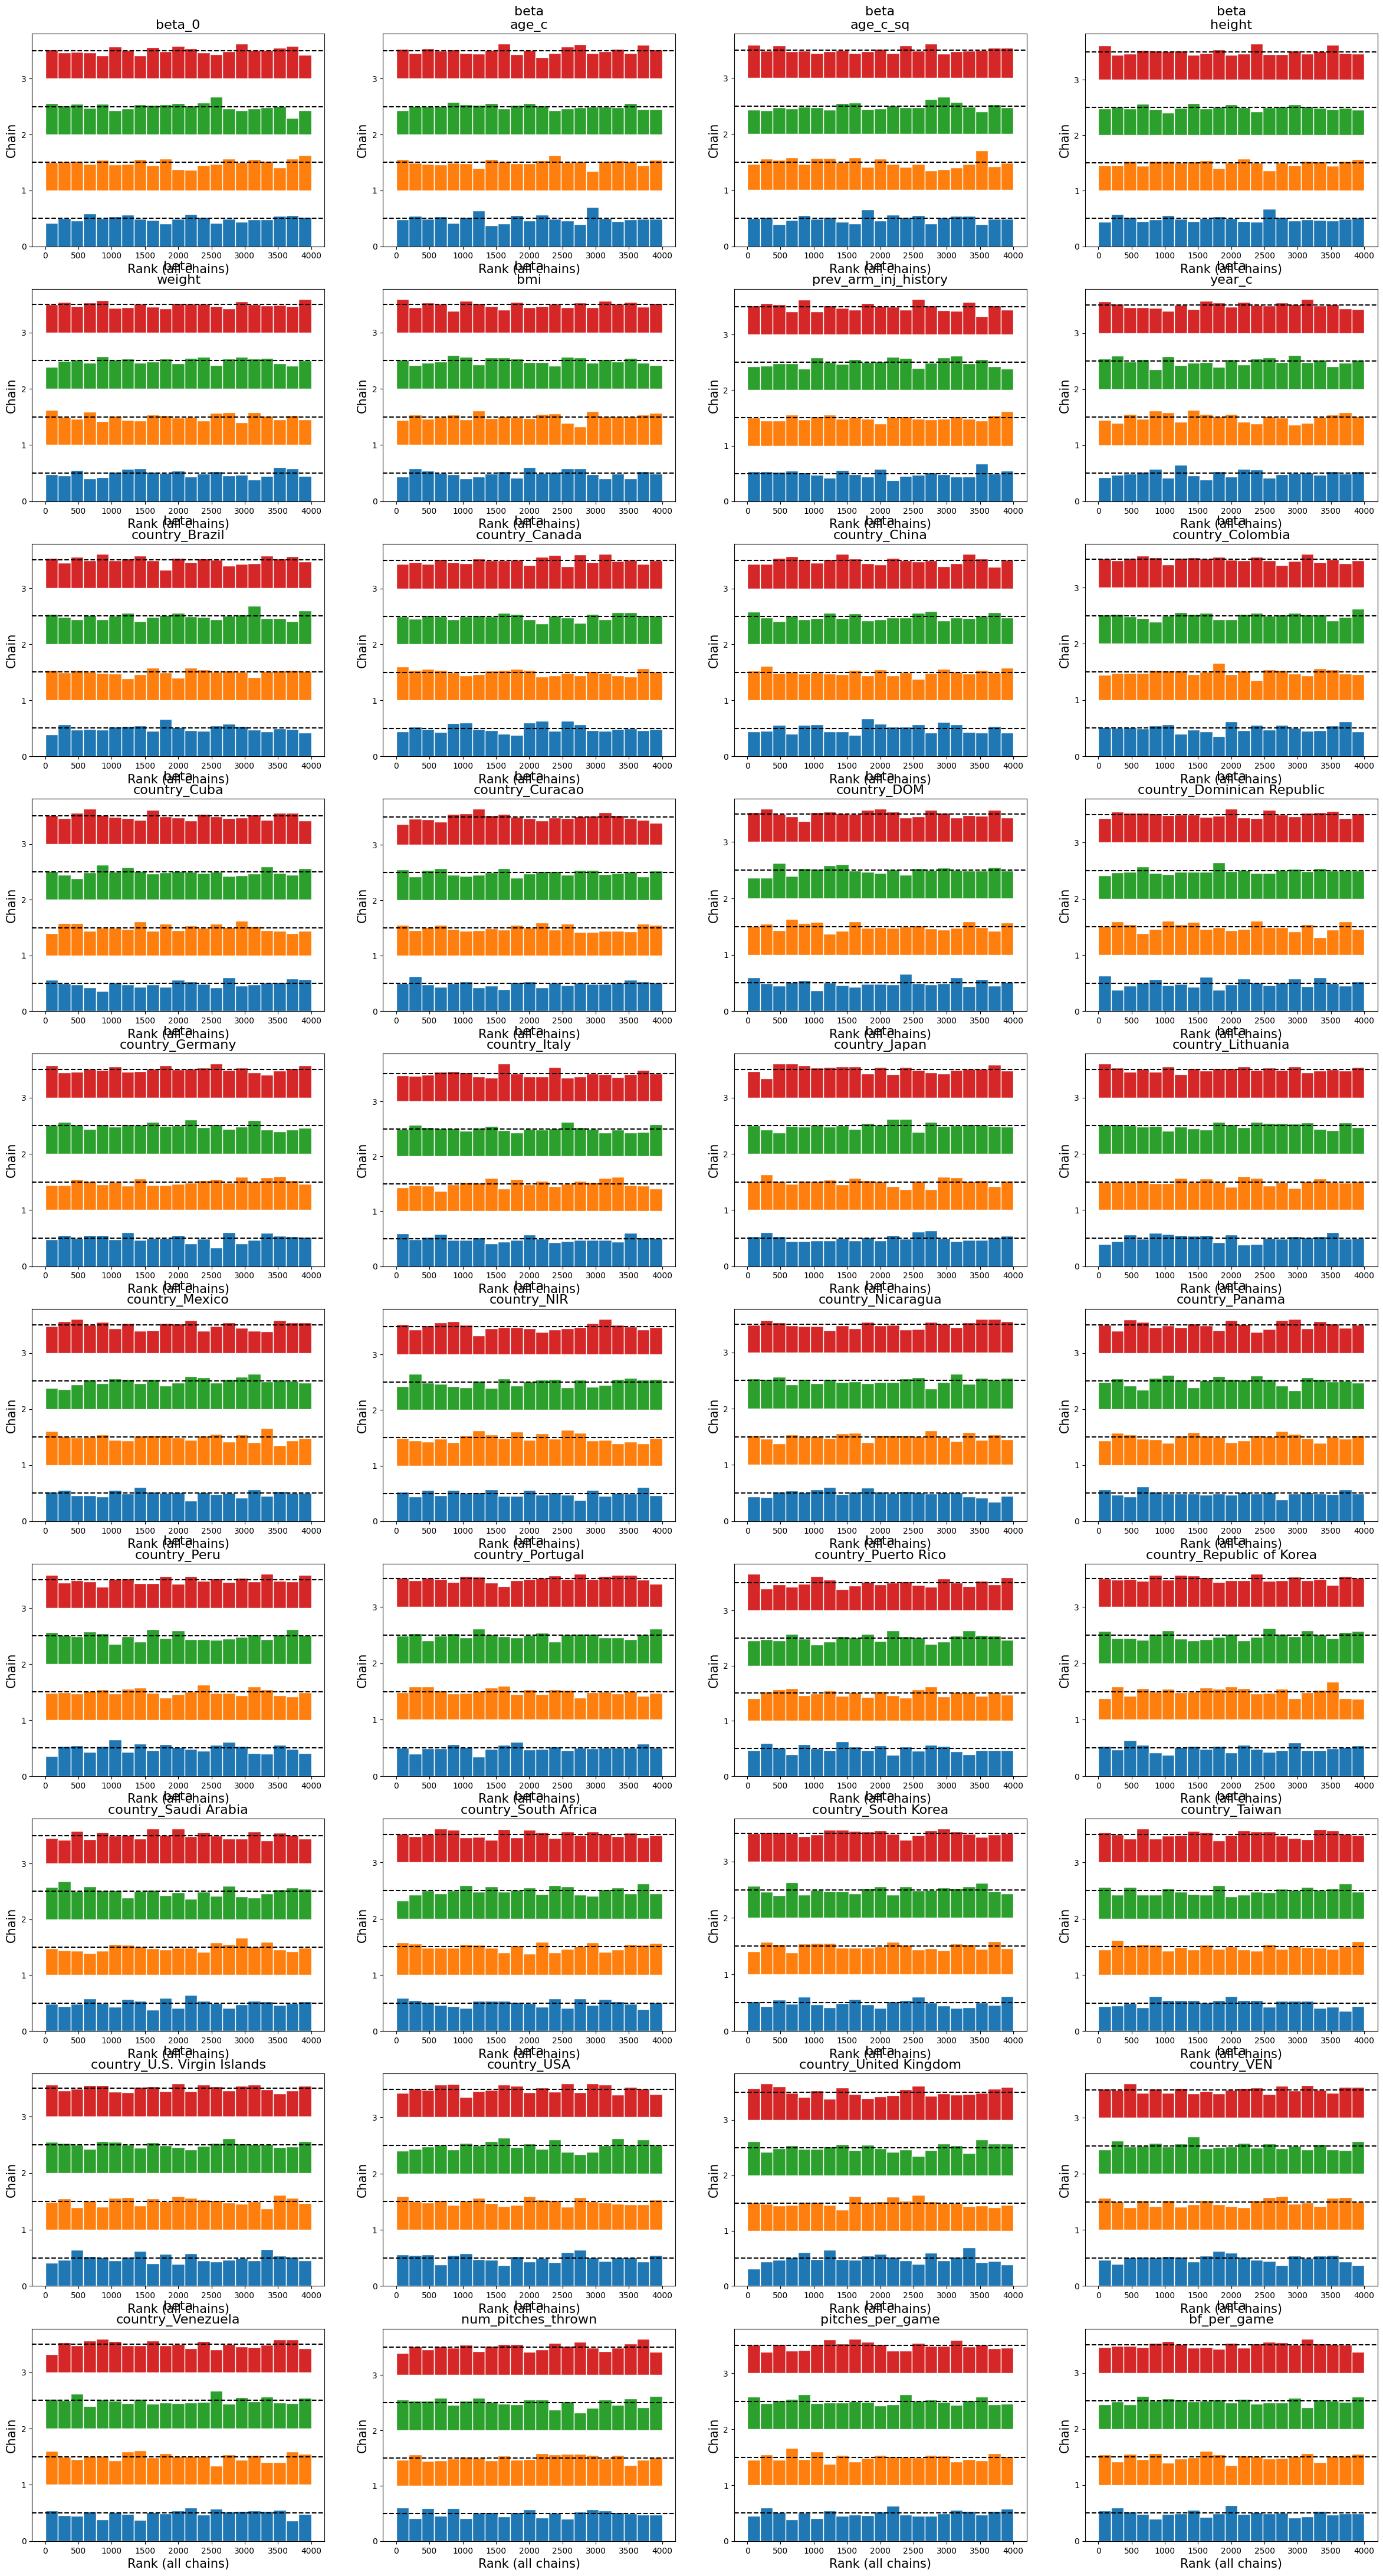

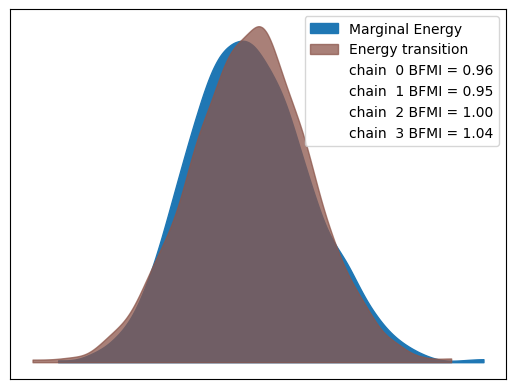

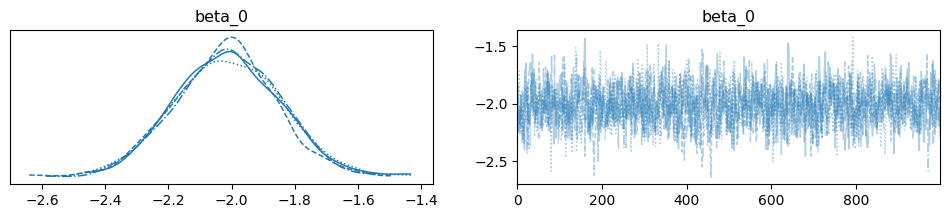

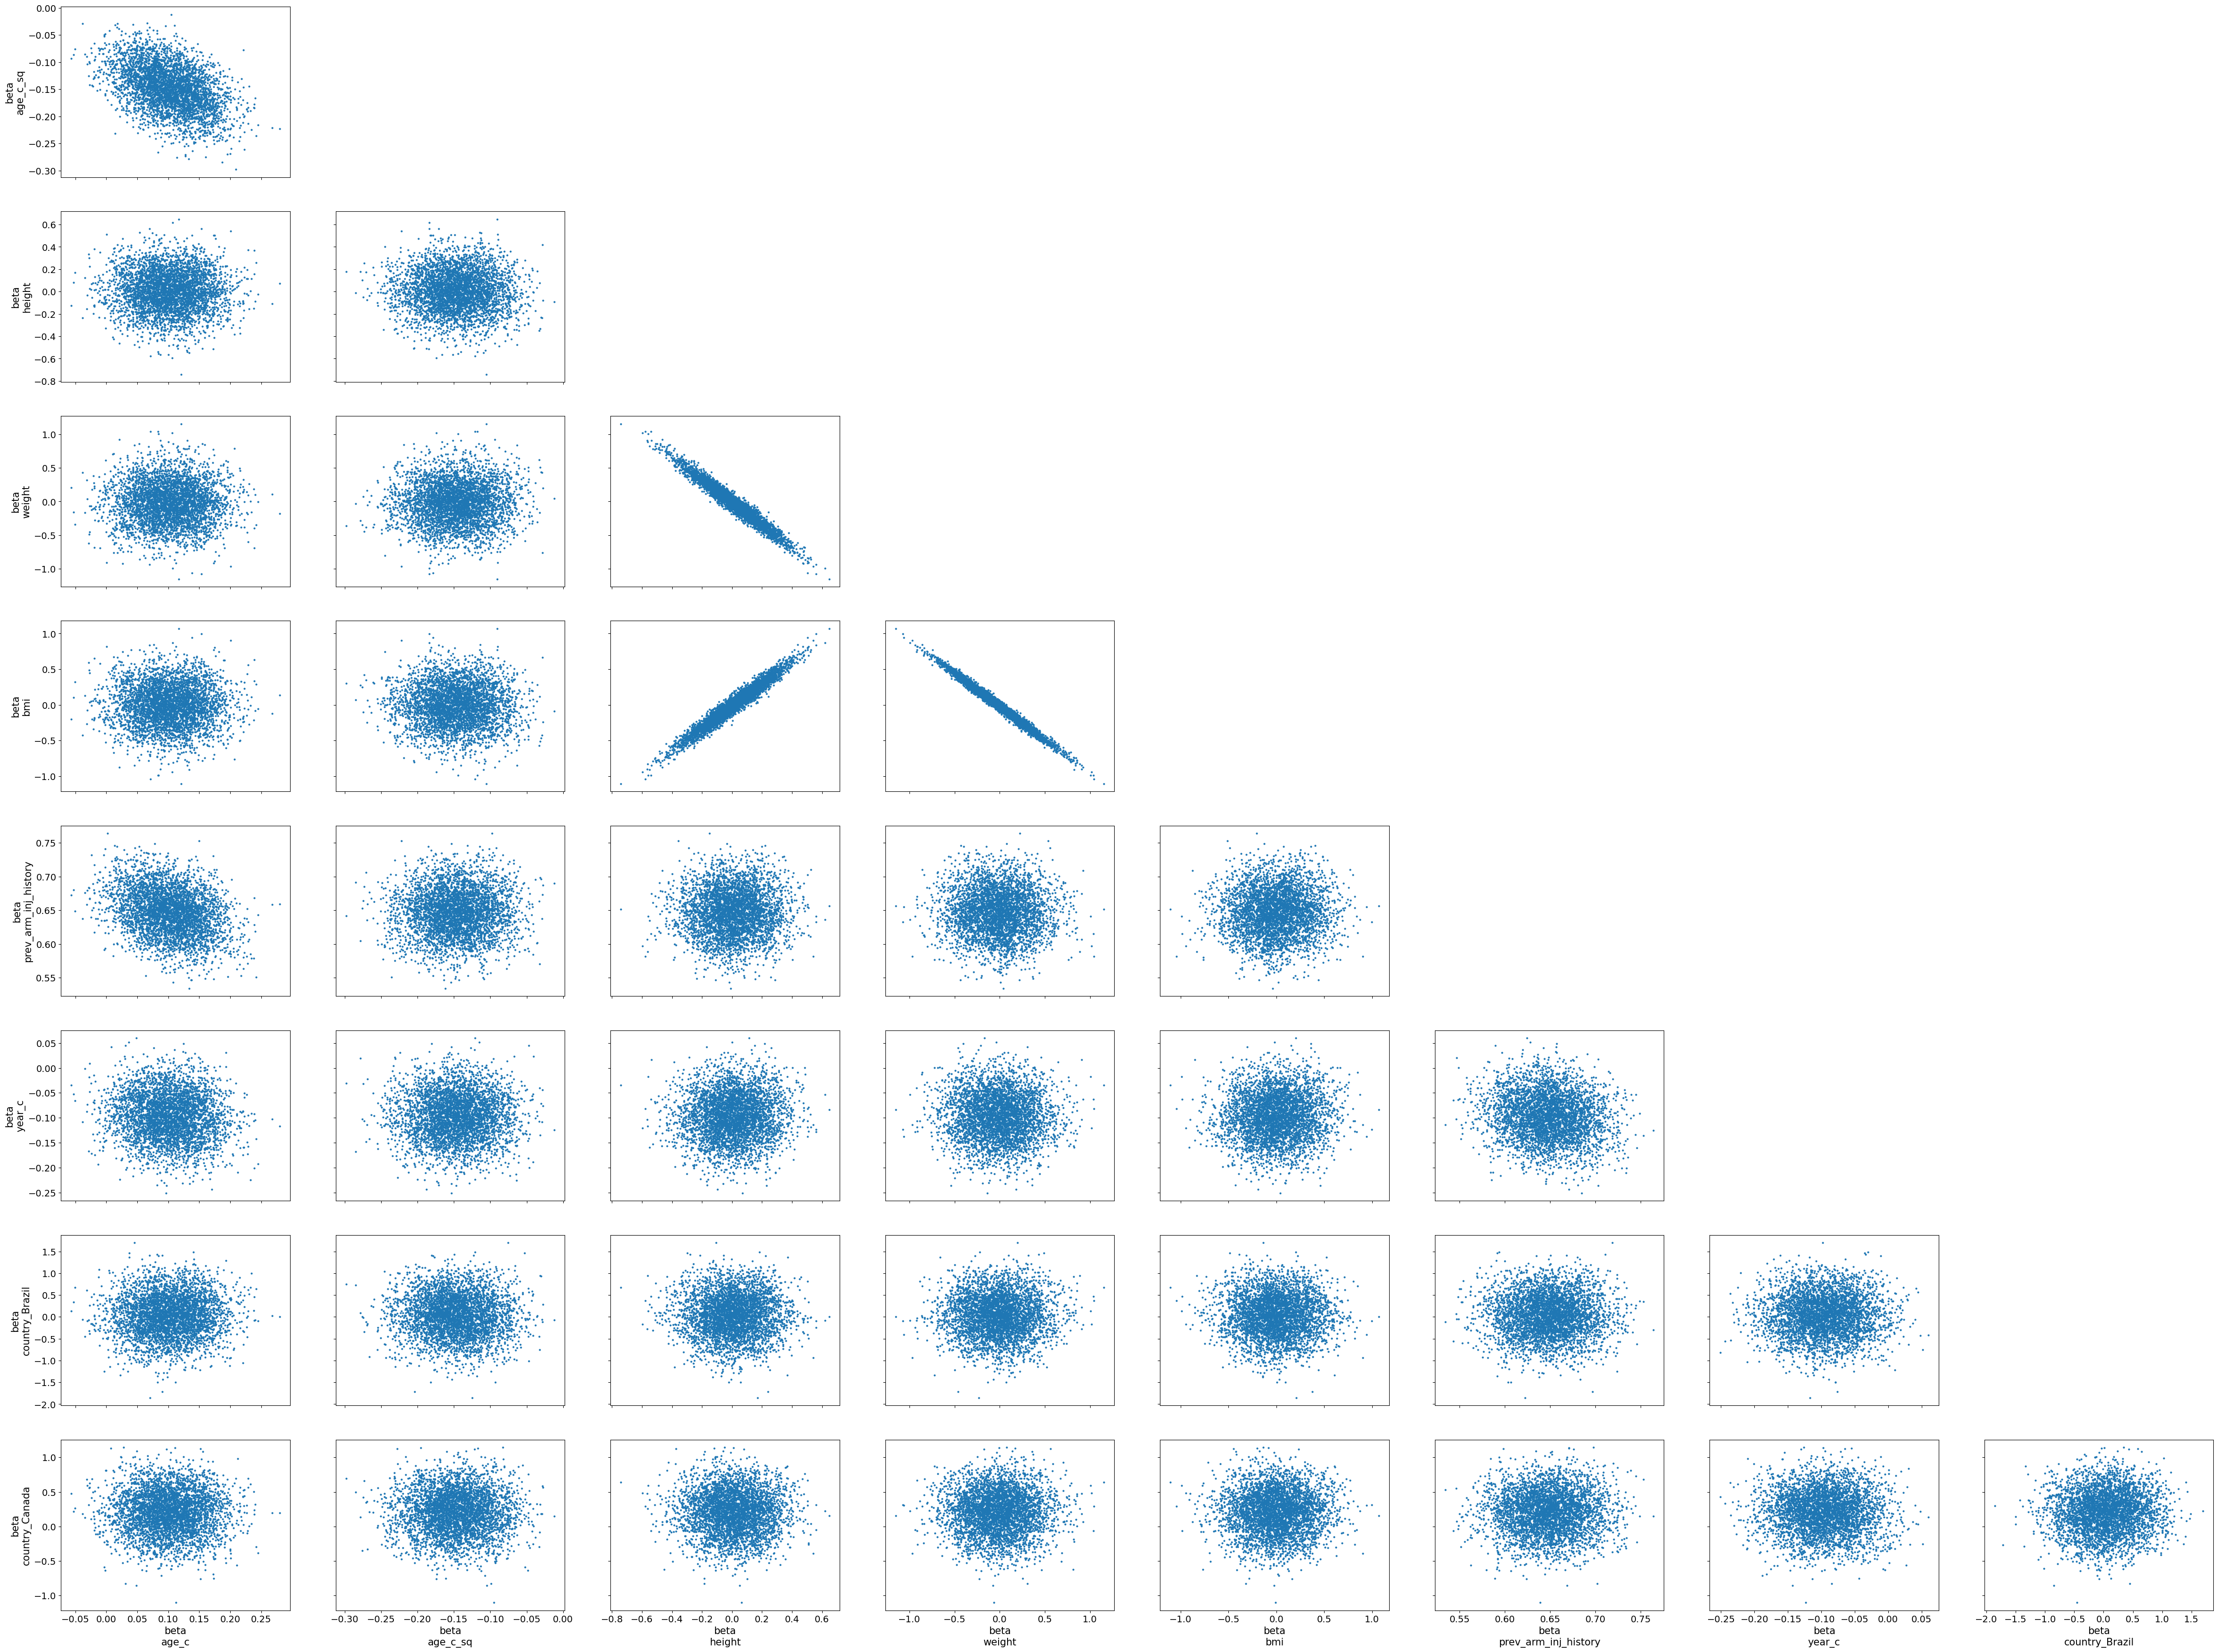

In [22]:
az.plot_rank(var1_trace)
az.plot_energy(var1_trace)
az.plot_trace(var1_trace, var_names=["beta_0"])
az.plot_pair(var1_trace, var_names=["beta"], divergences=True)

In [26]:
with logit_model_var1:
    ppc_2026 = pm.sample_posterior_predictive(var1_trace, var_names=["y_obs"], var_names=["p_pred"])

SyntaxError: keyword argument repeated: var_names (845748694.py, line 2)

In [25]:
idata_ppc = az.from_pymc(posterior_predictive=ppc_2026, model=logit_model_var1)

plt.figure(figsize=(10, 6))
az.plot_ppc(idata_ppc, kind="bar", figsize=(10, 6))
plt.title("Posterior Predictive Check — Bayesian Logistic Regression")
plt.show()

AttributeError: module 'arviz' has no attribute 'from_pymc'

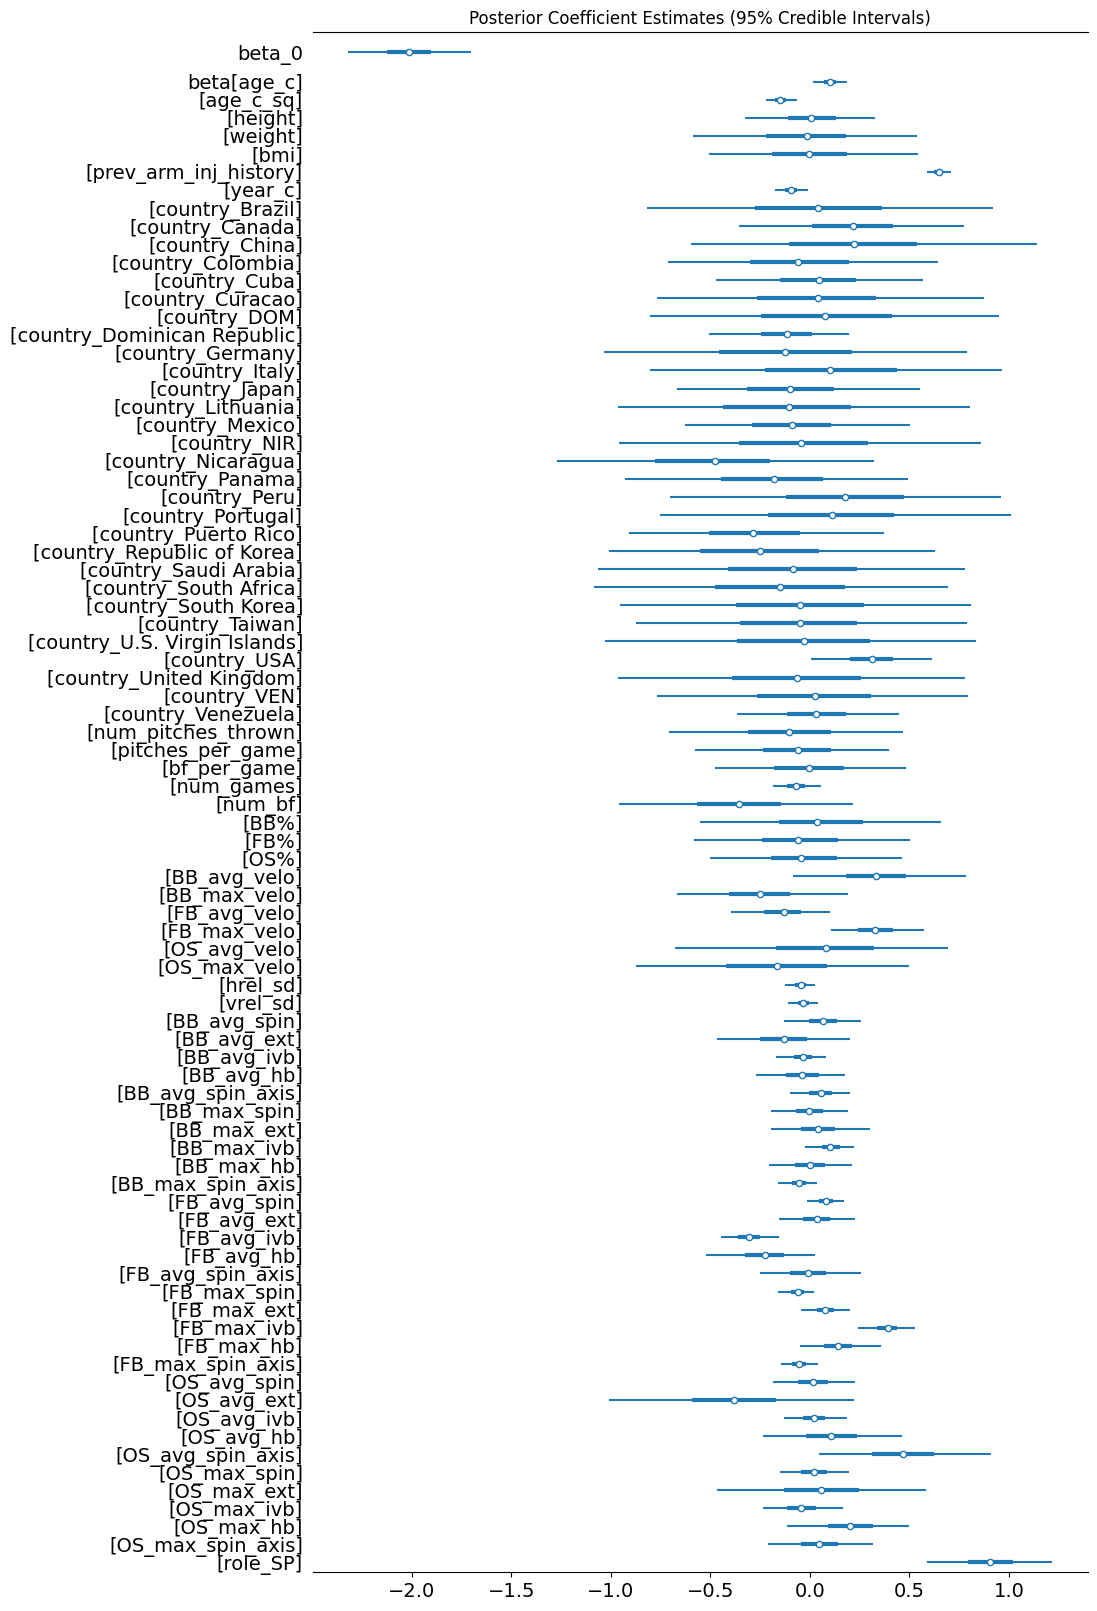

In [24]:
az.plot_forest(var1_trace, var_names=["beta_0", "beta"], combined=True, figsize=(10, 20))
plt.title("Posterior Coefficient Estimates (95% Credible Intervals)")
plt.show()